# 🧠 Patient Adherence Prediction: A Mini Case Study

#### Using anonymized patient appointment data 🗂️, we aim to predict the likelihood of a patient missing their next appointment 📅❌, helping healthcare providers 🏥 optimize follow-ups 🔁 and reduce dropouts 📉.


### Summary 
- Rows 110K
- Total 14 features- Key features: `ScheduledDay`, `AppointmentDay`, `Age`, `Gender`, `No-show`, `SMS_received`, etc.
- Target: No-show (Yes = missed, No = attended)

### Data Issues and challenges observed during analysis
- Imbalance data.
- age has value -1.

1 ## 📋 Key Observations from Binary Features Analysis

Below are the key patterns observed in no-show behavior across various binary medical and behavioral features:

| Feature         | Higher No-show Rate in | Difference & Insight                                                                 |
|----------------|------------------------|----------------------------------------------------------------------------------------|
| 🎓 Scholarship   | ✅ Scholarship (1)        | Scholarship recipients had slightly higher no-show rates, possibly linked to deeper socioeconomic issues. |
| 🩺 Hypertension  | ❌ No Hypertension (0)   | Patients without hypertension missed more appointments, while hypertensive patients were more consistent. |
| 🍩 Diabetes      | ❌ No Diabetes (0)        | Diabetics showed better adherence, likely due to the need for regular care.            |
| 🍷 Alcoholism    | ⚖️ Similar in both       | No significant difference — alcoholism didn’t strongly impact no-show behavior.        |
| ♿ Handicap       | ✅ Higher Handicap (3–4) | No-show rate increased with severity — possibly due to mobility or access challenges.  |
| 📩 SMS Received  | ✅ SMS Received (1)      | Counterintuitive: No-show rate was higher **despite** receiving SMS — may reflect poor timing, ineffective messaging, or alert fatigue. |

---

### 🧠 Takeaway:
Most chronic conditions (hypertension, diabetes) **correlate with better appointment adherence**, suggesting stronger engagement with the healthcare system.  
However, higher no-show rates among **scholarship recipients and highly handicapped patients** highlight the need for **targeted support and accessibility solutions**.  
Interestingly, **SMS reminders alone may not improve adherence**, and their effectiveness should be reassessed.


In [28]:
# Required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

In [29]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wbadry/noshow-appointment-may-2016")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\wbadry\noshow-appointment-may-2016\versions\1


In [30]:
df = pd.read_csv(r"C:\Users\user\.cache\kagglehub\datasets\wbadry\noshow-appointment-may-2016\versions\1\noshowappointments-kagglev2-may-2016.csv")


### 1. Dataset Overview

In [31]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [32]:
print("Total rows:", df.shape[0])
print("Total columns:", df.shape[1])


Total rows: 110527
Total columns: 14


In [33]:
print("Columns:", df.columns)

Columns: Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')


In [34]:
print("Data types:", df.dtypes)

Data types: PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object


In [35]:
print("Missing values:", df.isnull().sum())

Missing values: PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64


### 2. Exploratory Data Analysis

In [36]:
print("Unique patient:", df["PatientId"].nunique())

Unique patient: 62299


In [37]:
print("Unique Appointment:", df["AppointmentID"].nunique())

Unique Appointment: 110527


In [38]:
df["No-show"].value_counts()

No-show
No     88208
Yes    22319
Name: count, dtype: int64

In [39]:
df["PatientId"] = df["PatientId"].astype(str)
df["AppointmentID"] = df["AppointmentID"].astype(str)

In [40]:
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"]).dt.date
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"]).dt.date

In [41]:
df['LeadTime'] = (pd.to_datetime(df['AppointmentDay']) - pd.to_datetime(df['ScheduledDay'])).dt.days

In [42]:
df[df['LeadTime'] < 0]


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,LeadTime
27033,7839272661752.0,5679978,M,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,-1
55226,7896293967868.0,5715660,F,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,-1
64175,24252258389979.0,5664962,F,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,-1
71533,998231581612122.0,5686628,F,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,-6
72362,3787481966821.0,5655637,M,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,-1


> ⚠️ **Data Quality Note**:  
> A few records had negative lead times (e.g., -1 or -6), which are logically invalid since appointments can't be scheduled *after* the appointment date. These were removed from the dataset to ensure model reliability.
> Let's remove them 


In [43]:
df = df[df['LeadTime'] >= 0].reset_index(drop=True)

In [44]:
# Create cross-tab: lead_time vs No-show
cross_tab_date_diff = pd.crosstab(
    index=df['LeadTime'],
    columns=df['No-show'],
    values=df['No-show'],
    aggfunc='count',
    margins=True
)


In [45]:
# Keep only valid lead times (e.g., 0–128 days)
cross_tab_date_diff = cross_tab_date_diff.head(129)

# Compute % no-show rate
cross_tab_date_diff["%-Noshow"] = round((cross_tab_date_diff["Yes"] / cross_tab_date_diff["All"]) * 100, 2)

# Reset index for plotting
cross_tab_date_diff.reset_index(inplace=True)


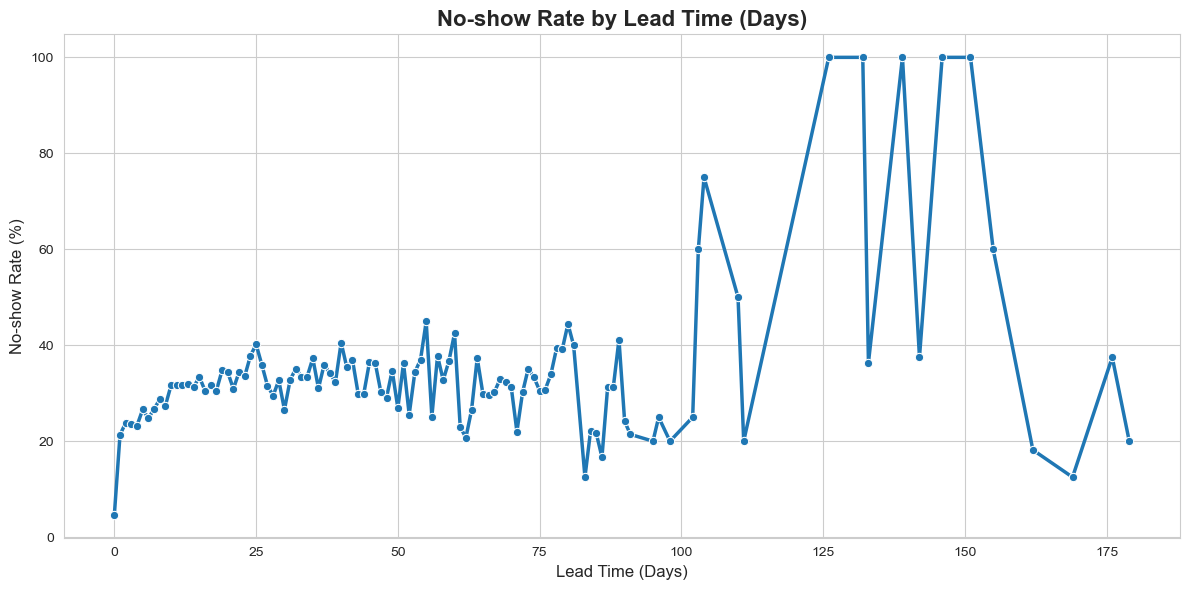

In [46]:
# Plot: No-show rate by lead time
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(
    data=cross_tab_date_diff,
    x="LeadTime",
    y="%-Noshow",
    marker="o",
    linewidth=2.5
)
plt.title("No-show Rate by Lead Time (Days)", fontsize=16, weight='bold')
plt.xlabel("Lead Time (Days)", fontsize=12)
plt.ylabel("No-show Rate (%)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

### 📊 No-show Rate vs Lead Time

We examine how the number of days between scheduling and the actual appointment affects patient behavior.

- Higher lead times may increase forgetfulness.
- Very short lead times may indicate emergency/urgent care.

This plot helps us explore such patterns.

### 📌 Observation:
The no-show rate remains fairly stable (~20–40%) for lead times under 90 days, but spikes unpredictably beyond 100 days, likely due to data sparsity or scheduling anomalies.


In [47]:
# Create cross-tab: lead_time vs No-show
cross_tab_age = pd.crosstab(
    index=df['Age'],
    columns=df['No-show'],
    values=df['No-show'],
    aggfunc='count',
    margins=True
)

# Age range: 0–103
cross_tab_age = cross_tab_age.head(104) 

# Compute % no-show rate
cross_tab_age["%-Noshow"] = round((cross_tab_age["Yes"] / cross_tab_age["All"]) * 100, 2)

# Reset index for plotting
cross_tab_age.reset_index(inplace=True)

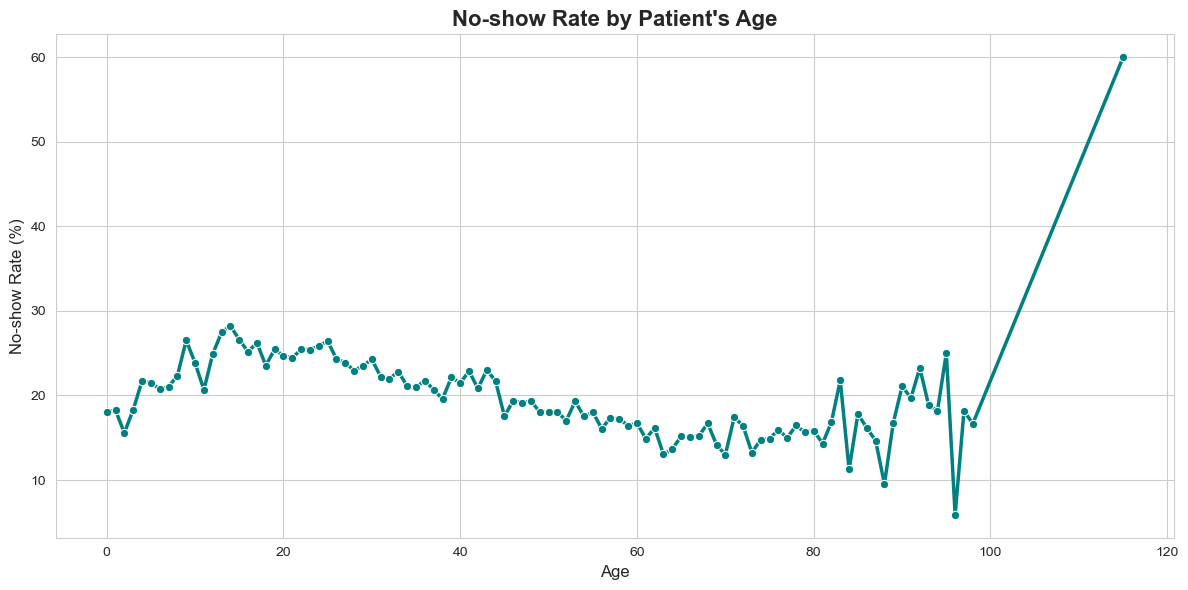

In [48]:
# Plotting
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(
    data=cross_tab_age,
    x="Age",
    y="%-Noshow",
    marker="o",
    linewidth=2.5,
    color="teal"
)
plt.title("No-show Rate by Patient's Age", fontsize=16, weight='bold')
plt.xlabel("Age", fontsize=12)
plt.ylabel("No-show Rate (%)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

### 📊 No-show Rate by Patient's Age

This chart analyzes how patient age influences the likelihood of missing a scheduled appointment.

- 👶 **Ages 0–20**:  
  No-show rates gradually increase to ~28%. This may reflect dependency on parents, school conflicts, or lower perceived urgency.

- 👨‍💼 **Ages 20–60**:  
  A steady decline in no-show rate (~18–20%) indicates better healthcare responsibility, possibly due to work-related health needs or structured routines.

- 👵 **Ages 60–90**:  
  No-show rates remain relatively stable and low, as this group likely includes patients with chronic conditions who prioritize appointments.

- ⚠️ **Ages 90+**:  
  Spikes (up to 60%) are visible, but these are likely due to **very few data points**, making them **statistically unreliable**.

---

**📌 Observation:**  
**Young (<20) and very elderly (>100)** patients show the highest no-show rates, while **middle-aged adults (20–60)** demonstrate the most consistent attendance patterns.



In [49]:
cross_tab_age

No-show,Age,No,Yes,All,%-Noshow
0,-1,1.0,NaN,1,NaN
1,0,2900.0,639.0,3539,18.06
2,1,1858.0,415.0,2273,18.26
3,2,1366.0,252.0,1618,15.57
4,3,1236.0,277.0,1513,18.31
...,...,...,...,...,...
99,98,5.0,1.0,6,16.67
100,99,1.0,NaN,1,NaN
101,100,4.0,NaN,4,NaN
102,102,2.0,NaN,2,NaN


### 🧹 Data Cleaning: Invalid Age Values

During data exploration, we identified a few records with an invalid age of `-1`. Since age cannot be negative, these rows were considered data entry errors and removed from the dataset, also **age>100** is also removed  

- 🔎 **Rows removed**: All entries with `Age < 0` (1 row) and `Age > 100`
- ✅ **Impact**: Improves the integrity of age-based analysis and modeling.


In [50]:
df = df[(df["Age"]>0) & (df["Age"]<100)].reset_index(drop=True)

In [51]:
# Crosstab: Neighborhood vs No-show
cross_tab_neigh = pd.crosstab(
    index=df["Neighbourhood"],
    columns=df["No-show"],
    values=df["No-show"],
    aggfunc="count",
    margins=False
)

# Calculate no-show percentage

cross_tab_neigh["%-Noshow"] = round((cross_tab_neigh["Yes"] / (cross_tab_neigh["Yes"] + cross_tab_neigh["No"])) * 100, 2)

# Sort by no-show rate (optional: or by total count)
cross_tab_neigh = cross_tab_neigh.sort_values(by="%-Noshow", ascending=False)

# Reset index for plotting
cross_tab_neigh.reset_index(inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_6900\3861029848.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


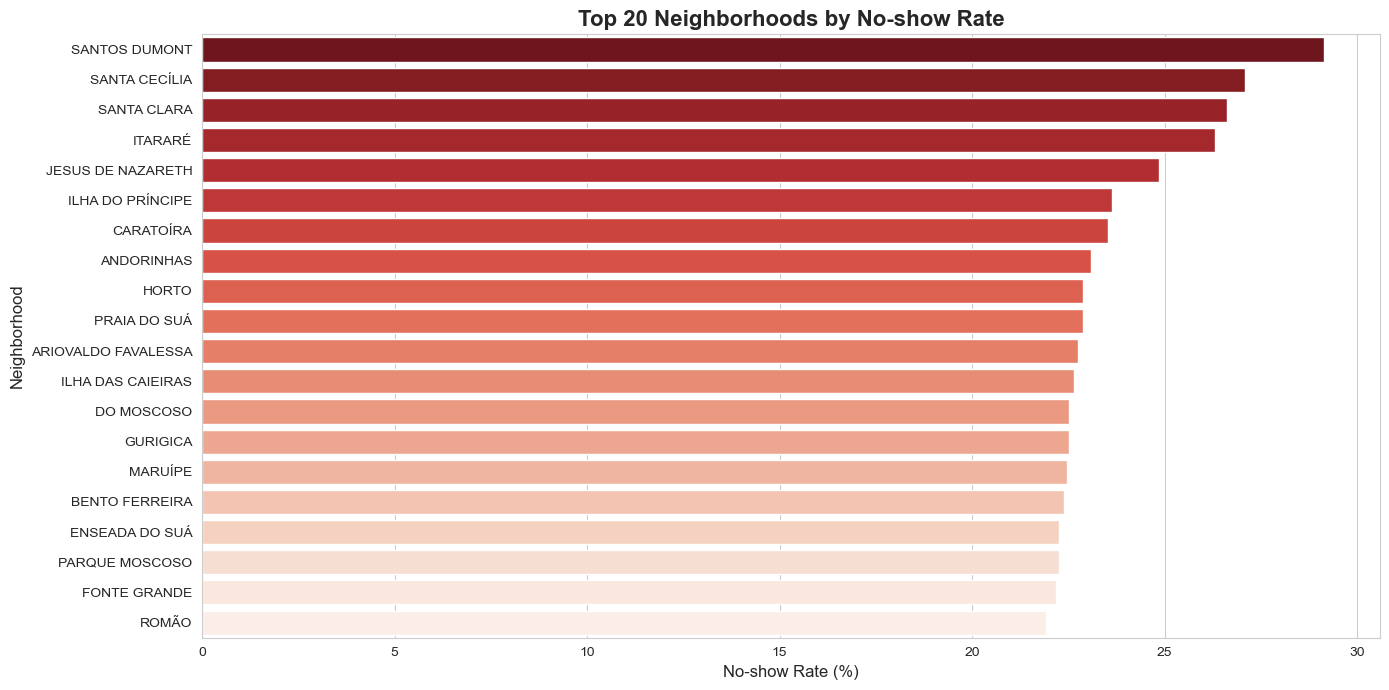

In [52]:
# Replot with a new shade
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
sns.barplot(
    data=cross_tab_neigh.head(20),
    x="%-Noshow",
    y="Neighbourhood",
    palette="Reds_r"  
)
plt.title("Top 20 Neighborhoods by No-show Rate", fontsize=16, weight='bold')
plt.xlabel("No-show Rate (%)", fontsize=12)
plt.ylabel("Neighborhood", fontsize=12)
plt.tight_layout()
plt.show()


### 🏙️ No-show Rate by Neighborhood

This chart highlights the top 20 neighborhoods with the highest no-show rates. These areas may benefit from targeted interventions such as community outreach, SMS/call reminders, or better transportation access.

**📌 Observations:**
- `SANTOS DUMONT`, `SANTA CECÍLIA`, and `SANTA CLARA` show no-show rates above **25%**, indicating significant attendance challenges.
- Most other neighborhoods in the top 20 fall between **18%–24%** no-show rate.
- Some of these areas may reflect **socioeconomic factors**, distance to clinics, or awareness levels influencing adherence.

Understanding these patterns enables **localized solutions** to reduce no-shows and improve public health impact.


In [53]:
# Function to generate cross-tab with no-show % calculation
def get_cross_tab(df, col1, col2): 
    cross_tab = pd.crosstab(
        index=df[col1],
        columns=df[col2],
        values=df[col2],
        aggfunc="count",
        margins=False
    )

    cross_tab["%-Noshow"] = round((cross_tab["Yes"] / (cross_tab["Yes"] + cross_tab["No"])) * 100, 2)
    cross_tab = cross_tab.sort_values(by="%-Noshow", ascending=False)
    cross_tab.reset_index(inplace=True)
    
    return cross_tab


In [54]:
# Function to plot vertical bar chart from cross-tab
def plot_cross_tab(df, x_col, y_col, x_label, y_label, title, palette="Blues_r"):
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")

    sns.barplot(
        data=df,
        x=x_col,
        y=y_col,
        palette=palette
    )

    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.tight_layout()
    plt.show()

In [55]:
cross_tab_sch = get_cross_tab(df, col1="Scholarship", col2="No-show")

In [ ]:
plot_cross_tab(cross_tab_sch, 
               x_col="Scholarship",
               y_col="%-Noshow", 
               x_label="Scholarship", 
               y_label="No-show Rate (%)", 
               title="No-show Rate by Scholarship",
               palette="Blues_r")

### 🎓 No-show Rate by Scholarship Status

This chart compares the no-show rate between patients who received a government scholarship (1) and those who did not (0).

- Patients with a scholarship exhibit a **higher no-show rate (~24%)** compared to non-recipients (~20%).
- This suggests that while financial support may reduce cost barriers, it might not be enough to ensure adherence — **non-financial challenges** like access, education, or personal health beliefs could still influence behavior.

**📌 Observation:**  
Receiving a scholarship does not guarantee better attendance. Targeted education, follow-ups, or community outreach may be needed for this group.


In [ ]:
cross_tab_hypT = get_cross_tab(df, col1="Hipertension", col2="No-show")

plot_cross_tab(cross_tab_hypT, 
               x_col="Hipertension",
               y_col="%-Noshow", 
               x_label="Hipertension", 
               y_label="No-show Rate (%)", 
               title="No-show Rate by Hypertension",
               palette="Blues_r")

### 🫀 No-show Rate by Hypertension Status

This bar chart compares the no-show rate between patients with (`1`) and without (`0`) a hypertension diagnosis.

- Patients **without hypertension** have a higher no-show rate (`~21%`) than those **with hypertension** (`~17.5%`).
- This pattern may reflect greater health consciousness or dependency on ro
- utine care among patients with chronic conditions.


**📌 Observation:**  
Patients with hypertension are more likely to adhere to appointments, possibly due to a higher perceived need for continuous care and monitoring.


In [ ]:
cross_tab_diabetes = get_cross_tab(df, col1="Diabetes", col2="No-show")

plot_cross_tab(cross_tab_diabetes, 
               x_col="Diabetes",
               y_col="%-Noshow", 
               x_label="Diabetes", 
               y_label="No-show Rate (%)", 
               title="No-show Rate by Diabetes",
               palette="Blues_r")

### 🍩 No-show Rate by Diabetes Status

This chart compares no-show rates between patients **with diabetes (1)** and those **without (0)**.

- Patients **with diabetes** have a lower no-show rate (`~18%`) than non-diabetic patients (`~20.5%`).
- This could reflect a greater urgency for ongoing medical attention and adherence to care among individuals managing chronic illnesses.

**📌 Observation:**  
Similar to other chronic conditions like hypertension, diabetic patients tend to be more reliable in attending appointments — likely due to the nature of their condition requiring regular follow-ups.


In [ ]:
cross_tab_alch = get_cross_tab(df, col1="Alcoholism", col2="No-show")

plot_cross_tab(cross_tab_alch, 
               x_col="Alcoholism",
               y_col="%-Noshow", 
               x_label="Alcoholism", 
               y_label="No-show Rate (%)", 
               title="No-show Rate by Alcoholism",
               palette="Blues_r")

### 🍷 No-show Rate by Alcoholism

This chart compares patients who **have** alcoholism (`1`) versus those who **don’t** (`0`).

- There is **little to no difference** between the two groups.
- Alcoholism does **not appear to significantly influence** appointment adherence.

**📌 Observation:**  
Unlike other chronic conditions, alcoholism doesn't show a clear impact on no-show behavior in this dataset.


In [ ]:
cross_tab_hand_cap = get_cross_tab(df, col1="Handcap", col2="No-show")

plot_cross_tab(cross_tab_hand_cap, 
               x_col="Handcap",
               y_col="%-Noshow", 
               x_label="Handcap", 
               y_label="No-show Rate (%)", 
               title="No-show Rate by Alcoholism",
               palette="Reds_r")

### ♿ No-show Rate by Handicap Level

This chart breaks down no-show rates across different handicap levels (0–4).

- Patients with **higher handicap levels (3–4)** show a noticeable **increase in no-show rates**, especially level 4 (~33%).
- This could be due to **mobility challenges**, transportation barriers, or caregiver dependency.

**📌 Observation:**  
As handicap severity increases, so does the no-show rate. These patients may need **extra support or home-based care options** to reduce missed visits.


In [ ]:
cross_tab_sms= get_cross_tab(df, col1="SMS_received", col2="No-show")

plot_cross_tab(cross_tab_sms, 
               x_col="SMS_received",
               y_col="%-Noshow", 
               x_label="SMS_received", 
               y_label="No-show Rate (%)", 
               title="No-show Rate by SMS_received",
               palette="Blues_r")

### 📩 No-show Rate by SMS Reminder

This chart compares no-show rates between patients who **did not receive** an SMS (`0`) and those who **did** (`1`).

- Surprisingly, patients who **received an SMS** had a **higher no-show rate (~27%)** compared to those who did not (~16%).
- This could indicate that **SMS alone is not effective** — or perhaps messages were sent too late, ignored, or not understood.

**📌 Observation:**  
SMS reminders alone may not be sufficient. Consider **timing, message clarity**, or combining SMS with **phone calls or in-person outreach**.


---

## 📦 Machine Learning Models: Logistic Regression, Random Forest, and XGBoost

In this section, we build and compare three supervised classification models to predict patient no-show behavior:

- **Logistic Regression** — a baseline linear model for binary classification.
- **Random Forest** — an ensemble of decision trees for capturing nonlinear relationships.
- **XGBoost** — a powerful gradient boosting algorithm known for its accuracy and performance.

We evaluate the models using the following metrics:
- 🎯 **Accuracy**: Overall correctness of the model
- 📏 **Precision**: Correctness of positive predictions
- 🔁 **Recall**: Coverage of actual positive cases
- 🧮 **F1-Score**: Balance between precision and recall

The best model will be selected based on **F1-Score**, given the class imbalance in no-show cases.


### ⚖️ Class Imbalance in No-show Prediction

In our dataset, the **distribution of the target variable (`No-show`) is imbalanced**, with more patients showing up than missing their appointments:

- `No (showed up)` = ~80%
- `Yes (no-show)` = ~20%

This imbalance can lead to misleading model performance — for example:
- A model predicting **everyone will show up** can still achieve **80% accuracy**, but will **fail to detect actual no-shows**.
- Metrics like **precision, recall, and F1-score** are more informative than accuracy alone in such cases.

**How we address it:**
- We use **F1-score** as the main metric for model comparison.
- Advanced options (for future improvement):
  - Use `class_weight='balanced'` in models like Logistic Regression or Random Forest.
  - Apply **oversampling (SMOTE)** or **undersampling** techniques.
  - Use **threshold tuning** or **probability-based scoring** instead of hard classification.

Understanding and mitigating class imbalance is essential to ensure models are useful in **real-world medical decision-making**.


In [ ]:

# Target variable
df['No-show'] = df['No-show'].map({'Yes': 1, 'No': 0})

# Features to use
features = ['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 
            'SMS_received', 'LeadTime']

# If needed, encode Gender (optional)
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # Male:1, Female:0
features.append('Gender')

X = df[features]
y = df['No-show']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# 🔧 Initialize Models with class_weight (for imbalance handling)
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


In [ ]:
# 🧠 Fit Models
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)


In [ ]:
# Predict probabilities
log_probs = log_reg.predict_proba(X_test)[:, 1]
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_probs = xgb.predict_proba(X_test)[:, 1]

In [ ]:
#  Predictions
log_preds = log_reg.predict(X_test)
rf_preds = rf.predict(X_test)
xgb_preds = xgb.predict(X_test)

In [ ]:
#  Evaluate Models
def evaluate_model(name, y_true, y_pred):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }


In [ ]:
results = [
    evaluate_model("Logistic Regression", y_test, log_preds),
    evaluate_model("Random Forest", y_test, rf_preds),
    evaluate_model("XGBoost", y_test, xgb_preds)
]

# 📋 Display Results
results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)
results_df

**📌 Observations:**
- Although XGBoost had the highest accuracy, its very low recall and F1-score make it unsuitable for our use case.
- Logistic Regression offered the best trade-off between detecting no-shows and avoiding false positives.
- We will consider **Logistic Regression** as the most suitable model for this problem, based on F1-score, given the class imbalance.


In [ ]:
# Calculate ROC curves and AUCs
log_fpr, log_tpr, _ = roc_curve(y_test, log_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

log_auc = roc_auc_score(y_test, log_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(log_fpr, log_tpr, label=f'Logistic Regression (AUC = {log_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


**📌 Observations:**
- **XGBoost** performs best, with the highest AUC, indicating a stronger ability to differentiate between patients who show up vs no-show.
- **Logistic Regression** is a good second, with moderate discriminatory power.
- **Random Forest** shows weaker performance in this specific problem.

The higher the AUC, the better the model is at distinguishing between classes, especially in imbalanced datasets like ours.

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Initialize models
log_reg_smote = LogisticRegression(max_iter=1000, class_weight='balanced')
rf_smote = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [ ]:
# Train models on resampled data
log_reg_smote.fit(X_resampled, y_resampled)
rf_smote.fit(X_resampled, y_resampled)
xgb_smote.fit(X_resampled, y_resampled)


In [ ]:
# Predict probabilities
log_smote_probs = log_reg_smote.predict_proba(X_test)[:, 1]
rf_smote_probs = rf_smote.predict_proba(X_test)[:, 1]
xgb_smote_probs = xgb_smote.predict_proba(X_test)[:, 1]

In [ ]:
# Predictions
log_preds_smote = log_reg_smote.predict(X_test)
rf_preds_smote = rf_smote.predict(X_test)
xgb_preds_smote = xgb_smote.predict(X_test)

In [ ]:
# Evaluate all models
results_smote = [
    evaluate_model("Logistic Regression (SMOTE)", y_test, log_preds_smote),
    evaluate_model("Random Forest (SMOTE)", y_test, rf_preds_smote),
    evaluate_model("XGBoost (SMOTE)", y_test, xgb_preds_smote)
]

In [ ]:
results_smote_df = pd.DataFrame(results_smote).sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

In [ ]:
results_smote_df

In [ ]:
# Calculate ROC curves and AUCs
log_fpr, log_tpr, _ = roc_curve(y_test, log_smote_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_smote_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_smote_probs)

log_smote_auc = roc_auc_score(y_test, log_smote_probs)
rf_smote_auc = roc_auc_score(y_test, rf_smote_probs)
xgb_smote_auc = roc_auc_score(y_test, xgb_smote_probs)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(log_fpr, log_tpr, label=f'Logistic Regression (AUC = {log_smote_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_smote_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_smote_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison with SMOTE')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


**📌 Observations:**
- **XGBoost** again performs best, maintaining strong separation between classes even after balancing.
- **Random Forest** and **Logistic Regression** slightly improved from their pre-SMOTE performance.
- This confirms that **handling class imbalance with SMOTE** can lead to better generalization and fairness in classification.


---

## 📌 Key Takeaways

- **Patient no-shows are imbalanced**: Only ~20% of patients missed appointments, making the dataset skewed.

- **Top features affecting no-shows** included:
  - Lead time between scheduling and appointment
  - Patient age
  - Whether the patient received an SMS
  - Scholarship and health conditions (e.g., hypertension, diabetes)

- **XGBoost initially had high AUC (0.73)** but performed poorly on recall and F1-score — it mostly predicted “show”.

- **SMOTE (Synthetic Minority Oversampling)** helped balance the data, improving all models' ability to detect no-shows.

- **After SMOTE**:
  - 📈 **XGBoost with SMOTE** had the best F1-score (**0.42**) and recall (**0.70**)
  - ✅ It became the best model for deployment when the goal is to **catch more no-shows**.

- **Logistic Regression with SMOTE** also performed well and is a good alternative when **simplicity and interpretability** are preferred.

---

👉 This approach can help clinics or hospitals **proactively target high-risk no-show patients** and take preventive actions like reminders, follow-ups, or overbooking strategies.
